In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

df = pd.read_csv("amz_uk_price_prediction_dataset.csv")

df.shape

(2443651, 9)

Part 1: Analyzing Best-Seller Trends Across Product Categories

Objective: Understand the relationship between product categories and their best-seller status.

In [61]:
#filtering out products with no reviews

df_filtered = df[df['reviews'] != 0]
display(df_filtered)

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
...,...,...,...,...,...,...,...,...,...
2443642,2828585,B07DCFQMQL,Speed MaxX BODY ARMOUR CE MOTORBIKE/MOTORCYCLE...,3.6,66,49.99,False,0,Motorbike Clothing
2443643,2828586,B07JM5VQFX,Motorcycle Clothing Suit - Motorbike Suit With...,4.1,5,158.99,False,0,Motorbike Clothing
2443644,2828587,B07X98JLFF,GREAT BIKERS GEAR - Bobber Cafe Brat Style Lea...,3.6,12,14.99,False,0,Motorbike Clothing
2443649,2828592,B008OYLL4I,Texpeed Mens Motorcycle Motorbike Biker Trouse...,4.3,404,79.99,False,0,Motorbike Clothing


In [76]:
#seperate dataset for numerical columns
df_numerical= df_filtered.select_dtypes("number").loc[:, df_filtered.select_dtypes("number").nunique() > 26].drop('uid', axis=1)
df_numerical.head()

,stars,reviews,price
0,4.7,15308,21.99
1,4.7,98099,23.99
2,4.7,15308,21.99
3,4.7,7205,31.99
4,4.6,1881,17.99


In [8]:
# Create a crosstab between the product category and the isBestSeller status.
crosstab_result = pd.crosstab(df_filtered['category'], df_filtered['isBestSeller'])

In [9]:
#Are there categories where being a best-seller is more prevalent? A: Material Handling Products, Smart Home Security & Lighting, Test & Measurement, Grocery, Health & Personal Care
crosstab_result['True/False Ratio'] = crosstab_result[True] / crosstab_result[False]
sorted_crosstab = crosstab_result.sort_values(by='True/False Ratio', ascending=False)
display(sorted_crosstab)

isBestSeller,False,True,True/False Ratio
category,,,
Material Handling Products,29,4,0.137931
Smart Home Security & Lighting,71,6,0.084507
Test & Measurement,47,3,0.063830
Grocery,8972,556,0.061971
Health & Personal Care,9007,552,0.061286
...,...,...,...
Boxes & Organisers,765,0,0.000000
Snowboard Boots,244,0,0.000000
Boating Footwear,19,0,0.000000


In [10]:
#Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
from scipy.stats import chi2_contingency

chi2_statistic, chi2_p_value, _, _ = chi2_contingency(pd.crosstab(df_filtered['category'], df_filtered['isBestSeller']))

chi2_statistic, chi2_p_value
#A: P-value lower than 0.05 indicates a strong association between the two values

(15380.142540443778, 0.0)

In [11]:
#Compute Cramér's V to understand the strength of association between best-seller status and category.
from scipy.stats.contingency import association

association(pd.crosstab(df_filtered['isBestSeller'], df_filtered['category']), method="cramer")

#Cramér's V value of 0.1 suggests a weak association between the two variables. Though statistically significant, the strength of this relationship is not very strong in practical terms.

0.11237113132728344

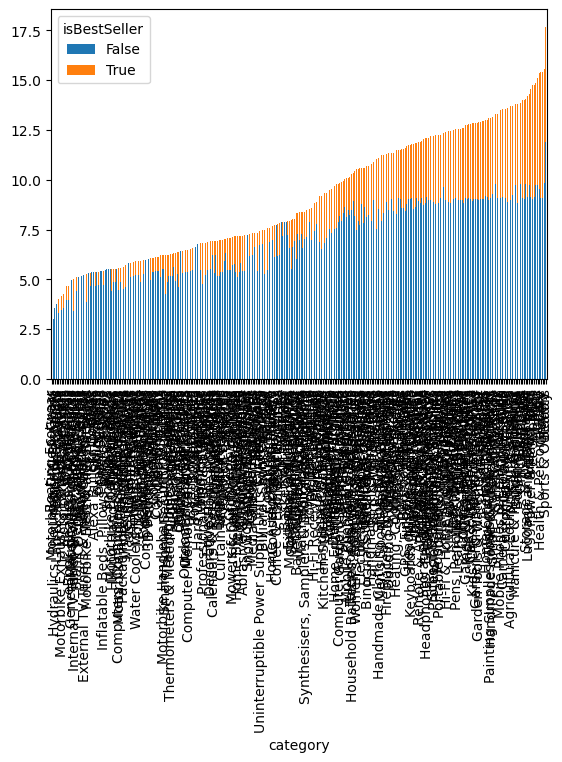

In [12]:
#Visualize the relationship between product categories and the best-seller status using a stacked bar chart at a logarithmic scale.

stacked_crosstab = pd.crosstab(df_filtered['category'], df_filtered['isBestSeller'])
log_crosstab = np.log1p(stacked_crosstab)
log_crosstab_sorted = log_crosstab.loc[log_crosstab.sum(axis=1).sort_values(ascending=True).index]
log_crosstab_sorted.plot(kind="bar", stacked=True);

Part 2: Exploring Product Prices and Ratings Across Categories and Brands
Objective: Investigate how different product categories influence product prices.

In [86]:
#Preliminary Step: Remove outliers in product prices.
#For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. 
#The next steps will be done with the dataframe without outliers.
#Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.

def tukeys_test_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify the outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]

    return lower_bound, upper_bound, outliers

# Apply the function
lower_bound, upper_bound, outliers = tukeys_test_outliers(df['price'])

# Filter out the outliers
df_filtered = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

display(df_filtered.head());

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


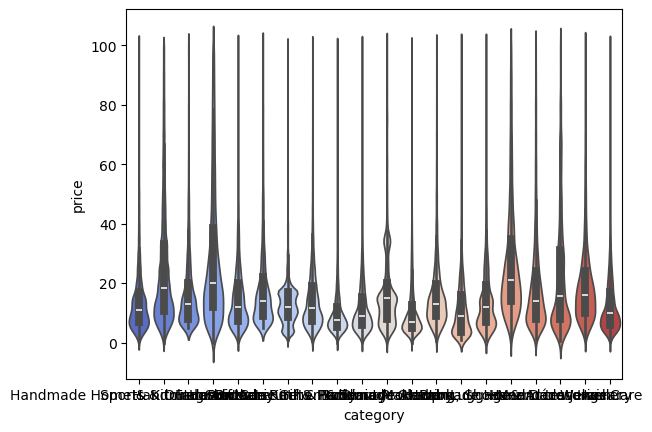

In [15]:
#Use a violin plot to visualize the distribution of price across different product categories. 
#Filter out the top 20 categories based on count for better visualization.
top_20_categories = df_filtered['category'].value_counts().head(20)
df_top_20 = df_filtered[df_filtered['category'].isin(top_20_categories.index)]
sns.violinplot(data=df_top_20, x='category', y='price', palette="coolwarm", hue='category', legend=False);

In [16]:
#Which product category tends to have the highest median price? Don't filter here by top categories. A: Laptops

median_prices = df.groupby('category')['price'].median()
sorted_medians = median_prices.sort_values(ascending=False)
df_sorted = df.set_index('category').loc[sorted_medians.index].reset_index()
display(df_sorted)

,category,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth
0,Laptops,329745,B0BWJ2357D,SGIN 15.6 Inch Laptop 8GB RAM 256GB SSD Celero...,4.4,1207,499.99,False,0
1,Laptops,329746,B0CG8ZQFWG,"ANMESC Laptop 15.6''with 12GB DDR4 512GB SSD, ...",4.6,13,299.99,True,0
2,Laptops,329747,B08N5N1WBH,"Apple 2020 MacBook Air Laptop M1 Chip, 13” Ret...",4.8,4037,835.00,False,0
3,Laptops,329748,B0CGX932KZ,"jumper 16 Inch Laptop, 16GB RAM 512GB SSD Lapt...",4.7,175,1199.99,False,0
4,Laptops,329749,B0C2VF24WW,Lenovo IdeaPad 3 Chromebook 14 Inch Full HD La...,4.0,89,154.95,False,0
...,...,...,...,...,...,...,...,...,...
2443646,Office Paper Products,2106771,B09S6KHQFN,20 x Moved House Cards from Olivia Samuel. A6 ...,4.9,22,5.75,False,0
2443647,Office Paper Products,2106772,B07YSFTWC9,Piccadilly Greetings Piccadilly Greetings Mode...,4.6,138,3.10,False,0
2443648,Office Paper Products,2106773,B00K6DYFB6,Twizler Funny Birthday Card with Polar Bear an...,4.6,109,3.99,False,0
2443649,Office Paper Products,2106774,B0C5M5BG26,ASTARON 30 Sheets Flower Bouquet Wrapping Pape...,4.6,30,13.88,False,0


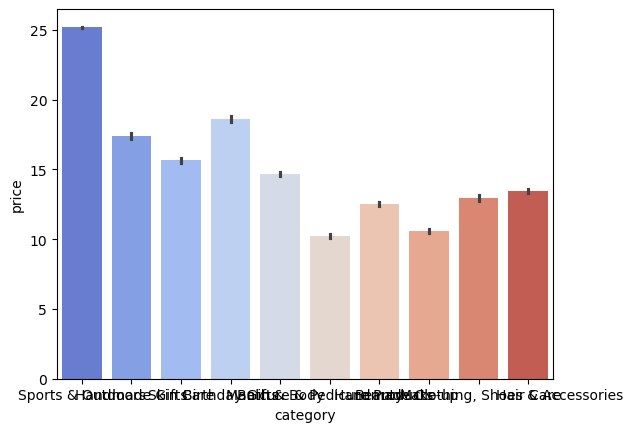

In [17]:
#Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
top_10_categories = df_filtered['category'].value_counts().head(10)
df_top_10 = df_filtered[df_filtered['category'].isin(top_10_categories.index)]
sns.barplot(data=df_top_10, x='category', y='price', palette="coolwarm", hue='category', legend=False);
                  

In [18]:
#Which product category commands the highest average price? Don't filter here by top categories. A: Laptops
average_prices = df.groupby('category')['price'].mean()
sorted_averages = average_prices.sort_values(ascending=False)
df_sorted = df.set_index('category').loc[sorted_averages.index].reset_index()
display(df_sorted)

,category,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth
0,Laptops,329745,B0BWJ2357D,SGIN 15.6 Inch Laptop 8GB RAM 256GB SSD Celero...,4.4,1207,499.99,False,0
1,Laptops,329746,B0CG8ZQFWG,"ANMESC Laptop 15.6''with 12GB DDR4 512GB SSD, ...",4.6,13,299.99,True,0
2,Laptops,329747,B08N5N1WBH,"Apple 2020 MacBook Air Laptop M1 Chip, 13” Ret...",4.8,4037,835.00,False,0
3,Laptops,329748,B0CGX932KZ,"jumper 16 Inch Laptop, 16GB RAM 512GB SSD Lapt...",4.7,175,1199.99,False,0
4,Laptops,329749,B0C2VF24WW,Lenovo IdeaPad 3 Chromebook 14 Inch Full HD La...,4.0,89,154.95,False,0
...,...,...,...,...,...,...,...,...,...
2443646,Office Paper Products,2106771,B09S6KHQFN,20 x Moved House Cards from Olivia Samuel. A6 ...,4.9,22,5.75,False,0
2443647,Office Paper Products,2106772,B07YSFTWC9,Piccadilly Greetings Piccadilly Greetings Mode...,4.6,138,3.10,False,0
2443648,Office Paper Products,2106773,B00K6DYFB6,Twizler Funny Birthday Card with Polar Bear an...,4.6,109,3.99,False,0
2443649,Office Paper Products,2106774,B0C5M5BG26,ASTARON 30 Sheets Flower Bouquet Wrapping Pape...,4.6,30,13.88,False,0


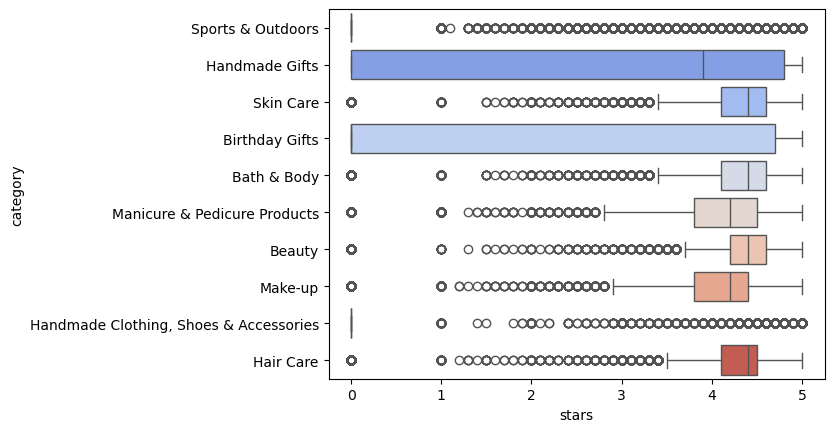

In [19]:
#Visualize the distribution of product ratings based on their category using side-by-side box plots. 
#Filter out the top 10 categories based on count for better visualization.
sns.boxplot(data=df_top_10, x='stars', y='category', palette="coolwarm", hue='category', legend=False);

In [20]:
#Which category tends to receive the highest median rating from customers? Don't filter here by top categories. A: Computer Memory

median_rating = df.groupby('category')['stars'].median()
sorted_ratings = median_rating.sort_values(ascending=False)
df_sorted1 = df.set_index('category').loc[sorted_ratings.index].reset_index()
display(df_sorted1)

,category,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth
0,Computer Memory,348960,B0BY6ZF5KF,Corsair VENGEANCE DDR5 RAM 192GB (4x48GB) 5200...,4.5,2,554.94,False,0
1,Computer Memory,348961,B082DH1FZR,Corsair VENGEANCE LPX DDR4 RAM 32GB (2x16GB) 3...,4.7,1645,69.97,False,0
2,Computer Memory,348962,B0143UM4TC,Corsair VENGEANCE LPX DDR4 RAM 16GB (2x8GB) 32...,4.8,55780,35.99,True,0
3,Computer Memory,348963,B0C29R9LNL,Crucial Pro RAM 32GB Kit (2x16GB) DDR4 3200MT/...,4.7,7234,51.99,False,0
4,Computer Memory,348964,B07RDKRRKM,Silicon Power DDR3 16GB (2 x 8GB) 1600MHz (PC3...,4.7,2478,19.99,False,0
...,...,...,...,...,...,...,...,...,...
2443646,eBook Readers & Accessories,2680960,B0C57BLMBN,MYLPDZSW HHF Tab Accessories Smart Case for On...,0.0,0,33.67,False,0
2443647,eBook Readers & Accessories,2680961,B09ZQSK9KS,XYFCJK Kindle Oasis 2 Case - 7Inch (9Th Gen) 2...,0.0,0,37.00,False,0
2443648,eBook Readers & Accessories,2680962,B0B7BHD9JR,UBBVPKY Ebook Reader Covers - Kindle Oasis 2/3...,0.0,0,36.00,False,0
2443649,eBook Readers & Accessories,2680963,B0B7BDDMRV,UBBVPKY Ebook Reader Covers - Kindle Oasis 2/3...,0.0,0,36.00,False,0


Part 3: Investigating the Interplay Between Product Prices and Ratings
Objective: Analyze how product ratings (stars) correlate with product prices.

In [22]:
#Calculate the correlation coefficient between price and stars.
print(f"Pearson correlation: ", df_filtered['stars'].corr(df_filtered['price']))
print(f"Spearman correlation: ", df_filtered['stars'].corr(df_filtered['price'], method='spearman'))

#Is there a significant correlation between product price and its rating? Correlation indicates that as price goes up, the rating tends to decrease

Pearson correlation:  -0.0776729987818137
Spearman correlation:  -0.06679697280768314


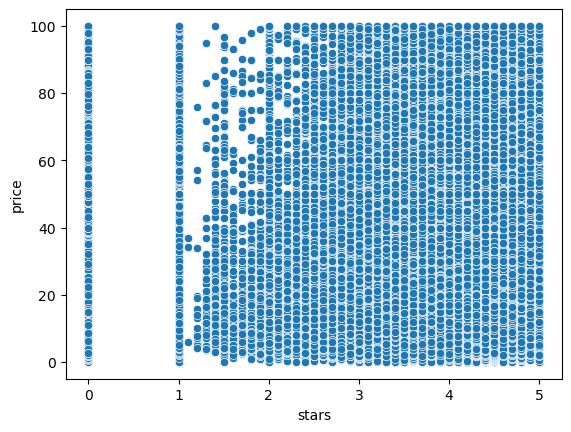

In [23]:
#Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe? A: most products have very high 

sns.scatterplot(data=df_filtered, x='stars', y='price');

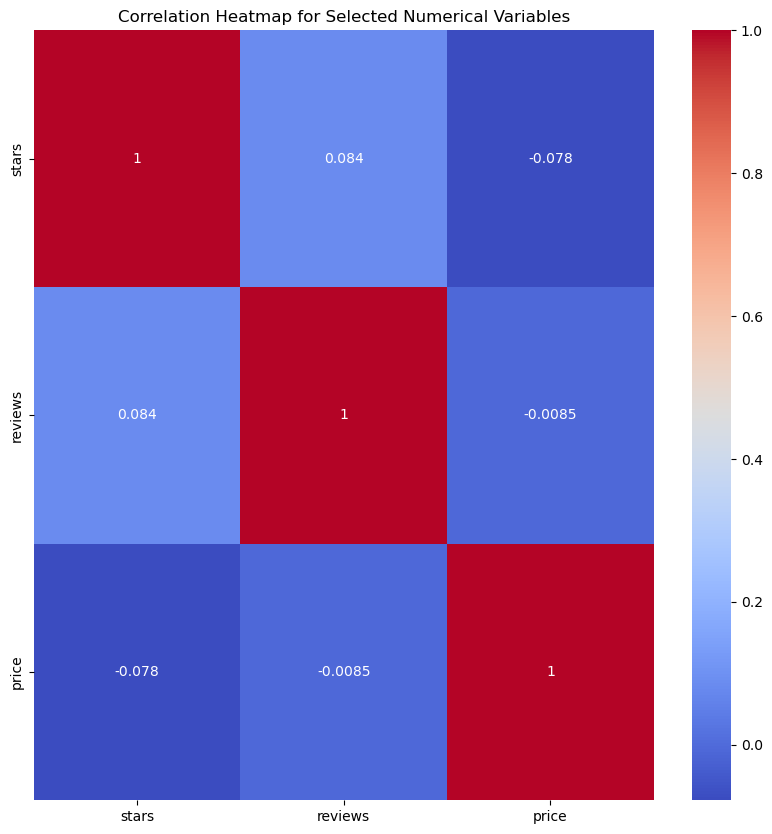

In [88]:
#Use a correlation heatmap to visualize correlations between all numerical variables.

df_numerical= df_filtered.select_dtypes("number").loc[:, df_filtered.select_dtypes("number").nunique() > 26].drop('uid', axis=1)

correlation_matrix = df_numerical.corr()

plt.figure(figsize=(10, 10))

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap for Selected Numerical Variables")
plt.show()

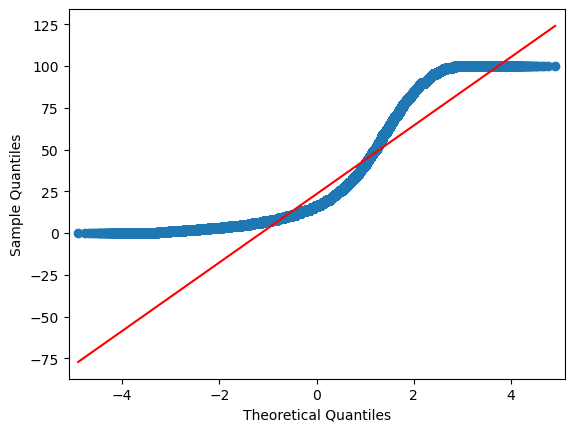

In [90]:
#Examine if product prices typically follow a normal distribution using a QQ plot.

import statsmodels.api as sm

# Generating a Q-Q plot for 'SalePrice' to check if its distribution follows a normal distribution
sm.qqplot(df_filtered['price'], line='s');

Report Summary

Comparing data from products with reviews, the most categories with the greatest porportion of best sellers are: Material Handling Products, Smart Home Security & Lighting, Test & Measurement, Grocery, Health & Personal Care. A low P-value lower indicates a strong association between specific categories and being a best seller, however, Cramer's V indicates a weak association between the two variables, meaning that though statistically significant, the strength of this relationship is not very strong in practical terms. The more products offered in a category, the more best sellers it will have, though not necessarily porportionally greater.

Products in the laptops category have the highest median and average price of all categories, however, Sports & Outdoors has the highest average price out of the top ten largest categories, likely due to the many outlier high prices in this category. Birthday and Handmade gifts have very wide range of rating in contrast to the other top ten categories, indicating a wide range of customer satifaction in these categories. Computer memory has the highest median range from customers. There is a correlation between higher priced items recieving lower ratings.